In [ ]:
from google.colab import drive
drive.mount ("/content/drive")

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Mar 29 04:23:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!python -m pip install --upgrade pip
%pip install mediapipe tensorflow cloud-tpu-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 KB 16.7 MB/s eta 0:00:00
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.0
    Uninstalling google-api-core-2.11.0:
      Successfully uninstalled google-api-core-2.11.0
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.70.0
    Uninstalling google-api-python-client-2.70.0:
      Successfully uninstalled google-api-python-client-2.70.0
ERROR: pip's dependency resolver does not currently take into account

In [ ]:
import os
import re
import cv2
import math
import random

import mediapipe as mp
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab.patches import cv2_imshow
from scipy.spatial.distance import euclidean as dist
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image

In [ ]:
%cd /content/drive/MyDrive/DDD_Team/DDD_data/140.114.77.242/Training_Evaluation_Dataset
%ls

/content/drive/.shortcut-targets-by-id/14G2kuLg9QULmrBMTniI9HHngL8ZL8TTo/DDD Team/DDD_data/140.114.77.242/Training_Evaluation_Dataset
'Evaluation Dataset'/    README.txt           transfer_learning/
'Evaluation Function'/   training_data/       validation_data/
 lightning_logs/        'Training Dataset'/


## Feature Definition

In [ ]:
RIGHT = [[33, 133], [160, 144], [159, 145], [158, 153]] # right eye landmark positions
LEFT = [[263, 362], [387, 373], [386, 374], [385, 380]] # left eye landmark positions
MOUTH = [[61, 291], [39, 181], [0, 17], [269, 405]] # mouth landmark coordinates

EYE_AR_THRESH = 0.26
PROB_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 15

MOUTH_AR_THRESH = 0.05
MOUTH_AR_CONSEC_FRAMES = 20


VARS = ["glasses","nightglasses","night_noglasses","noglasses","sunglasses"]
VIDEOS = ["yawning","slowBlinkWithNodding","sleepyCombination","nonsleepyCombination"]

def get_EAR(landmarks,eye):
    ''' Calculate the ratio of the eye length to eye width.
    :param landmarks: Face Landmarks returned from FaceMesh MediaPipe model
    :param eye: List containing positions which correspond to the eye
    :return: Eye aspect ratio value
    '''
    N1 = dist(landmarks[eye[1][0]], landmarks[eye[1][1]])
    N2 = dist(landmarks[eye[2][0]], landmarks[eye[2][1]])
    N3 = dist(landmarks[eye[3][0]], landmarks[eye[3][1]])
    D = dist(landmarks[eye[0][0]], landmarks[eye[0][1]])
    return (N1 + N2 + N3) / (3 * D)

def get_eye_feature(landmarks):
    ''' Calculate the eye feature as the average of the eye aspect ratio for the two eyes
    :param landmarks: Face Landmarks returned from FaceMesh MediaPipe model
    :return: Eye feature value
    '''
    return (get_EAR(landmarks,LEFT) + get_EAR(landmarks,RIGHT))

def get_mouth_feature(landmarks):
    ''' Calculate mouth feature as the ratio of the mouth length to mouth width
    :param landmarks: Face Landmarks returned from FaceMesh MediaPipe model
    :return: Mouth feature value
    '''
    N1 = dist(landmarks[MOUTH[1][0]], landmarks[MOUTH[1][1]])
    N2 = dist(landmarks[MOUTH[2][0]], landmarks[MOUTH[2][1]])
    N3 = dist(landmarks[MOUTH[3][0]], landmarks[MOUTH[3][1]])
    D = dist(landmarks[MOUTH[0][0]], landmarks[MOUTH[0][1]])
    return (N1 + N2 + N3)/(3*D)

## Image Processing

In [ ]:
TRAIN_DIR_PATH = os.getcwd()+"/Training Dataset"
TRAIN_DIR_FILES = os.listdir(TRAIN_DIR_PATH)
VALID_DIR_PATH = os.getcwd()+"/Evaluation Dataset"
VALID_DIR_FILES = os.listdir(VALID_DIR_PATH)

IMG_HEIGHT = 224
IMG_WIDTH = 224

VID_PATH = ""

MP_FACE_DETECTION = mp.solutions.face_detection
MP_DRAWING = mp.solutions.drawing_utils
MP_DRAWING_STYLES = mp.solutions.drawing_styles
MP_FACE_MESH = mp.solutions.face_mesh
DRAWING_SPEC = MP_DRAWING.DrawingSpec(thickness=1, circle_radius=1)

def set_path(dir_num="",var="",root=TRAIN_DIR_PATH):
  global VID_PATH
  if var=="":
    VID_PATH = root + '/' + dir_num + '/'
  else:
    VID_PATH = root + '/' + dir_num + '/' + var + '/'


def get_paths(videos_folder):
  return [os.path.join(videos_folder,vid) for vid in os.listdir(videos_folder)]

def get_labels(file_name) -> list[int]:
  labels = []
  try:
    with open(file_name,'r') as f:
      for ch in f.readline():
        labels.append(int(ch))
    return labels
  except FileNotFoundError:
    return labels


def process_mp_img(img,show_img=False):
  """
    returns features and/or processed image
  """
  with MP_FACE_MESH.FaceMesh(
    min_detection_confidence=0.3,
    min_tracking_confidence=0.8) as face_mesh:

    # convert the img to RGB and process it with MediaPipe Face Detection
    results = face_mesh.process(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks is not None:
      landmark_pos = []
      for i, data in enumerate(results.multi_face_landmarks[0].landmark):
        landmark_pos.append([data.x, data.y, data.z])
      landmark_pos = np.array(landmark_pos)

      # draw face detections of each face
      annotated_img = img.copy()
      for face_landmarks in results.multi_face_landmarks:
        # Calculate eye and mouth features
        eye_feature = get_eye_feature(landmark_pos)
        mouth_feature = get_mouth_feature(landmark_pos)

        # Binary classification: drowsy (1) or non-drowsy (0)
        drowsy = (eye_feature < EYE_AR_THRESH) or (mouth_feature > MOUTH_AR_THRESH)

        # face mesh
        MP_DRAWING.draw_landmarks(
            image=annotated_img,
            landmark_list=face_landmarks,
            connections=MP_FACE_MESH.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=MP_DRAWING_STYLES
              .get_default_face_mesh_tesselation_style()
        )
        # eyes and mouth regions
        MP_DRAWING.draw_landmarks(
            image=annotated_img,
            landmark_list=face_landmarks,
            connections=MP_FACE_MESH.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=MP_DRAWING_STYLES
              .get_default_face_mesh_contours_style()
        )

        cv2.resize(annotated_img,(IMG_HEIGHT,IMG_WIDTH))
        if show_img == True:
            cv2_imshow(annotated_img)
  return eye_feature, mouth_feature, drowsy

def mediapipe_process(data,labels):
    mp_features = {}
    eye_features_all = []
    mouth_features_all = []

    # Extract eye and mouth features for all videos
    for index,video in enumerate(data):
        mp_features[video] = {"eye_feature": [], "mouth_feature": []}
        num_frames = len(labels[index])
        capture = cv2.VideoCapture(video)
        total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_interval = total_frames // num_frames

        frames_processed = 0
        frame_idx = 0

        while frames_processed < num_frames:
            capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = capture.read()

            if not ret:
                break

            eye_feature, mouth_feature, drowsy = process_mp_img(frame)

            frame_idx += frame_interval
            frames_processed += 1
            mp_features[video]["eye_feature"].append(eye_feature)
            mp_features[video]["mouth_feature"].append(mouth_feature)
            eye_features_all.append(eye_feature)
            mouth_features_all.append(mouth_feature)
        capture.release()

    # Calculate mean and standard deviation for normalization
    eye_mean, eye_std = np.mean(eye_features_all), np.std(eye_features_all)
    mouth_mean, mouth_std = np.mean(mouth_features_all), np.std(mouth_features_all)

    # Normalize eye and mouth features for all videos
    for video in mp_features:
        mp_features[video]["eye_feature"] = (np.array(mp_features[video]["eye_feature"]) - eye_mean) / eye_std
        mp_features[video]["mouth_feature"] = (np.array(mp_features[video]["mouth_feature"]) - mouth_mean) / mouth_std

    return mp_features



def extract_frames(video_path, frame_indices, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    cap = cv2.VideoCapture(video_path)

    frames = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, target_size)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame / 255.0
            frames.append(frame)

    cap.release()
    return np.array(frames)


## Testing

In [ ]:
%ls "$VALID_DIR_PATH/030"

030_glasses_mixing_drowsiness.txt          030_night_noglasses_mixing_mouth.txt
030_glasses_mixing_eye.txt                 030_nightnoglasses_mix.mp4
030_glasses_mixing_head.txt                030_noglasses_mixing_drowsiness.txt
030_glasses_mixing_mouth.txt               030_noglasses_mixing_eye.txt
030_glasses_mix.mp4                        030_noglasses_mixing_head.txt
030_nightglasses_mixing_drowsiness.txt     030_noglasses_mixing_mouth.txt
030_nightglasses_mixing_eye.txt            030_noglasses_mix.mp4
030_nightglasses_mixing_head.txt           030_sunglasses_mixing_drowsiness.txt
030_nightglasses_mixing_mouth.txt          030_sunglasses_mixing_eye.txt
030_nightglasses_mix.mp4                   030_sunglasses_mixing_head.txt
030_night_noglasses_mixing_drowsiness.txt  030_sunglasses_mixing_mouth.txt
030_night_noglasses_mixing_eye.txt         030_sunglasses_mix.mp4
030_night_noglasses_mixing_head.txt


In [ ]:
def get_all_data(root=TRAIN_DIR_FILES):
  data = {}
  if root==TRAIN_DIR_FILES:
    for dir in root:
      for var in VARS:
        set_path(dir,var,root=TRAIN_DIR_PATH)
        for video in VIDEOS:
          data[VID_PATH+video+'.avi'] = get_labels(f"{VID_PATH}{dir}_{video}_drowsiness.txt")

  elif root==VALID_DIR_FILES:
    for dir in root:
      set_path(dir,var="",root=VALID_DIR_PATH)
      for var in VARS:
        data[f"{VID_PATH}{dir}_{var}_mix.mp4"] = get_labels(f"{VID_PATH}{dir}_{var}_mixing_drowsiness.txt")
  return {k:v for k,v in data.items() if len(v)!=0}

all_training_data = get_all_data(root=TRAIN_DIR_FILES)
train_video_paths = list(all_training_data.keys())
train_video_labels = list(all_training_data.values())

all_eval_data = get_all_data(root=VALID_DIR_FILES)
valid_video_paths = list(all_eval_data.keys())
valid_video_labels = list(all_eval_data.values())

In [ ]:
print(len(valid_video_labels[0]))

3045


In [ ]:
new_labels = sorted(valid_video_labels,key=lambda x: len(x))
len(new_labels[-1])

17458

In [ ]:
frame_dict = {vid:extract_frames(vid) for vid in train_video_paths}
print(frame_dict)

In [ ]:
mp_features = mediapipe_process(train_video_paths,train_video_labels)

TypeError: ignored

In [ ]:
%cd "$IMG_PATH"

[Errno 2] No such file or directory: '$IMG_PATH'
/content/drive/.shortcut-targets-by-id/14G2kuLg9QULmrBMTniI9HHngL8ZL8TTo/DDD Team/DDD_data/140.114.77.242/Training_Evaluation_Dataset


Image: frame_0.png


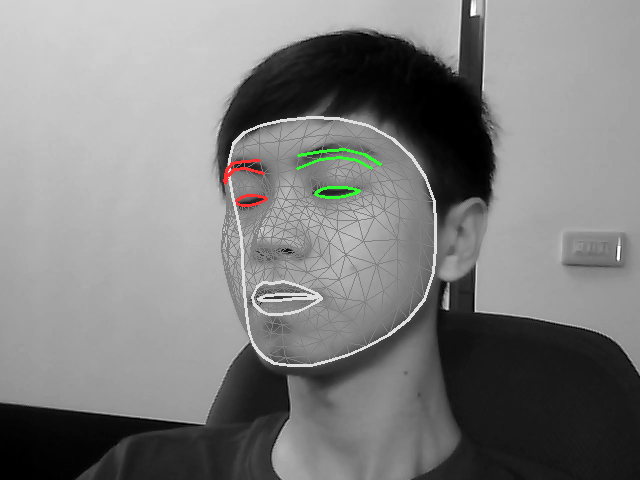

In [ ]:
process_img(images[0],mp_flag=True)

# Supervised Learning, Labelled Data, and Fine-tuning


In [ ]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
],name="data_augmentation")

In [ ]:
def split_path(video_path, type):
  path_parts = video_path.split(os.path.sep)
  last_three_parts = path_parts[-3:]
  last_part_without_ext = os.path.splitext(last_three_parts[-1])[0]
  last_three_parts[-1] = last_part_without_ext
  new_path = "_".join(last_three_parts)
  if type=="training_data":
    return new_path
  elif type=="validation_data":
    return last_part_without_ext

def save_frames_as_images(video_path,label,frame_dict,output_dir, target_size=(224, 224)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_resized = cv2.resize(frame, target_size)
        frame_filename = os.path.join(output_dir, f"{split_path(video_path,output_dir)}_frame_{frame_count}.png")
        print(f"Saving {frame_filename}...")
        frame_dict[frame_filename]=label[frame_count]
        cv2.imwrite(frame_filename, frame_resized)

        frame_count += 1

    cap.release()


In [ ]:
# frame_dict = {}
# for video,label in all_training_data.items():
#   save_frames_as_images(video,label,frame_dict,output_dir="training_data")

Streaming output truncated to the last 5000 lines.
Saving training_data/036_sunglasses_sleepyCombination_frame_2199.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2200.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2201.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2202.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2203.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2204.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2205.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2206.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2207.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2208.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2209.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2210.png...
Saving training_data/036_sunglasses_sleepyCombination_frame_2211.png...
Saving traini

In [ ]:
# val_frame_dict = {}
# for video,label in all_eval_data.items():
#   save_frames_as_images(video,label,val_frame_dict,output_dir="validation_data")

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

def image_generator(frame_dict, batch_size, target_size=(224, 224)):
    image_paths = list(frame_dict.keys())
    num_images = len(image_paths)

    while True:
        # Shuffle the image paths before each epoch
        np.random.shuffle(image_paths)

        for i in range(0, num_images, batch_size):
            batch_image_paths = image_paths[i:i + batch_size]
            batch_images = []
            batch_labels = []

            for path in batch_image_paths:
                # Read image
                image = cv2.imread(path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Preprocess image
                preprocessed_image = load_and_prep_image(image)

                batch_images.append(preprocessed_image)
                batch_labels.append(frame_dict[path])

            yield np.array(batch_images), np.array(batch_labels)


In [ ]:
batch_size = 16
train_generator = image_generator(frame_dict, batch_size)
val_generator = image_generator(val_dict, batch_size)

In [ ]:
#Load the EfficientNetV2-S model with pre-trained weights from ImageNet

BASE_MODEL = tf.keras.applications.EfficientNetV2B0(
    input_shape=(IMG_HEIGHT,IMG_WIDTH,3),
    include_top=False,
    weights='imagenet'
)

def EfficientNet(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), base_model=BASE_MODEL, num_classes=2):
  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False

  # create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  x = data_augmentation(inputs)

  x = base_model(x, training=False)

  x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)

  outputs = layers.Dense(num_classes,activation='sigmoid',name="output_layer")(x)

  # Create a new model with the EfficientNetV2-S base model and a Global Average Pooling layer
  model = keras.Model(inputs, outputs)
  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
efficient_net_model = EfficientNet()
efficient_net_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 2)                 2562      
                                                             

In [ ]:
print(efficient_net_model.layers[3].dtype)
print(efficient_net_model.layers[3].dtype_policy)

float32
<Policy "float32">


In [ ]:
#!mkdir -p transfer_learning/tensorboard_logs

In [ ]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Train model
efficient_net_model = efficient_net_model.fit(train_generator,
                                              epochs=5,
                                              steps_per_epoch=len(train_video_paths),
                                              validation_data=val_generator,
                                              validation_steps=int(0.25*len(valid_video_paths)),
                                              callbacks=[create_tensorboard_callback("transfer_learning", "tensorboard_logs")])

Saving TensorBoard log files to: transfer_learning/tensorboard_logs/20230329-012748


<ipython-input-25-09070194ecf2>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame_indices = np.linspace(0, total_frames - 1, len(labels), dtype=np.int)
<ipython-input-25-09070194ecf2>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yield np.array(X), np.array(y)


ValueError: ignored

In [ ]:
efficient_net_model.save("en_model_v1")

## Upload Models to Google Storage
* Google AI Platform requires the model to be in `SavedModel` format to serve it.[link text](https://)
* TFLite Model for Raspberry Pi

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

In [ ]:
!gsutil cp -r en_model_v1 gs://

## LSTM Model (Convert to TF-Keras)

In [ ]:
def get_feature_vectors(videos=train_video_paths,labels=train_video_labels,features=feature_extractor):
  feature_vectors = []
  for vid in videos:
    frames,labels = extract_frames(vid, labels, (IMG_HEIGHT,IMG_WIDTH))
    feature_vectors.append([np.squeeze(feature_extractor.predict(frame)) for frame in frames])
  return feature_vectors

def create_sequences(features, seq_length):
    sequences = []
    for i in range(len(features) - seq_length + 1):
        sequence = features[i:i + seq_length]
        sequences.append(sequence)
    return sequences


# EfficientNet model that outputs feature vectors
feature_layer = efficient_net_model.get_layer("global_avg_pooling_layer")
feature_extractor = Model(inputs=efficient_net_model.input,outputs=feature_layer.output)
efficientnet_features = get_feature_vectors(train_video_paths,train_video_labels,feature_extractor)

seq_length = 10  # Choose an appropriate value for your problem
feature_vector_sequences = create_sequences(feature_vectors, seq_length)
mp_features_sequences = create_sequences(mp_features, seq_length)

# Normalize EfficientNet feature vectors
scaler_efficientnet = MinMaxScaler()
efficientnet_normalized = [scaler_efficientnet.fit_transform(seq) for seq in feature_vector_sequences]

# Normalize Mediapipe features
scaler_mediapipe = MinMaxScaler()
mediapipe_normalized = [scaler_mediapipe.fit_transform(seq) for seq in mp_features_sequences]

concatenated_sequences = [np.concatenate((en_seq, mp_seq), axis=1) for en_seq, mp_seq in zip(efficientnet_normalized, mediapipe_normalized)]

In [ ]:
class DrowsinessDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_sequences = concatenated_sequences[:int(0.8 * len(concatenated_sequences))]
train_labels = labels[:int(0.8 * len(labels))]

train_dataset = DrowsinessDataset(train_sequences, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
input_size = train_sequences[0].shape[-1]
hidden_size = 128
num_layers = 1
num_classes = 2

In [ ]:
class LSTMDrowsinessClassifier(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMDrowsinessClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        sequences, labels = batch
        logits = self(sequences)
        loss = nn.CrossEntropyLoss()(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, labels = batch
        logits = self(sequences)
        loss = nn.CrossEntropyLoss()(logits, labels)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [ ]:
lstm_model = LSTMDrowsinessClassifier(input_size, hidden_size, num_layers, num_classes)

# Train the model
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')  # Change gpus=1 to use GPU
trainer.fit(lstm_model, train_dataloader, val_dataloader)